In [4]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

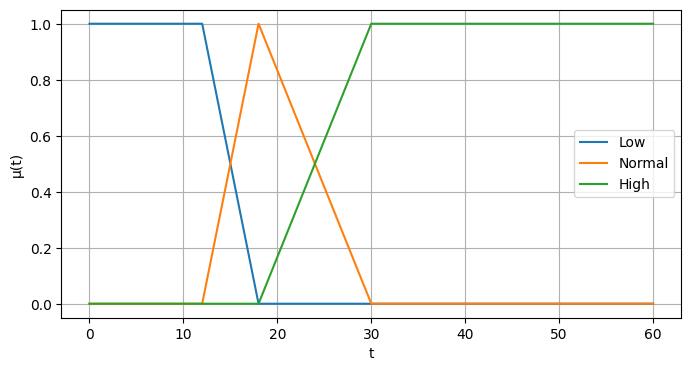

In [13]:
temperature = ctrl.Antecedent(np.arange(0, 61, 1), 'temperature')
fan_speed = ctrl.Consequent(np.arange(0, 1001, 1), 'fan_speed')
t = temperature.universe
f = fan_speed.universe

# ---- μ_Low(t) ----
low = np.zeros_like(t, dtype=float)
# 1 при 0 ≤ t ≤ 12
low[(t >= 0) & (t <= 12)] = 1
# -1/6*t + 3 при 12 < t ≤ 18
mask = (t > 12) & (t <= 18)
low[mask] = -1/6*t[mask] + 3
# 0 после 18 (уже стоит)

# ---- μ_Normal(t) ----
normal = np.zeros_like(t, dtype=float)
# (1/6)*t - 2, 12 < t ≤ 18
mask = (t > 12) & (t <= 18)
normal[mask] = (1/6)*t[mask] - 2
# -1/12*t + 5/2, 18 < t ≤ 30
mask = (t > 18) & (t <= 30)
normal[mask] = -1/12*t[mask] + 5/2

# ---- μ_High(t) ----
high = np.zeros_like(t, dtype=float)
# 1/12*t - 3/2, 18 < t ≤ 30
mask = (t > 18) & (t <= 30)
high[mask] = (1/12)*t[mask] - 3/2
# 1 при 30 < t ≤ 60
high[(t > 30) & (t <= 60)] = 1

temperature["low"] = low
temperature["normal"] = normal
temperature["high"] = high

# --- ПЛОТ ---
plt.figure(figsize=(8,4))
plt.plot(t, low,   label='Low')
plt.plot(t, normal,label='Normal')
plt.plot(t, high,  label='High')
plt.ylim(-0.05,1.05)
plt.grid(True)
plt.legend()
plt.xlabel('t')
plt.ylabel('μ(t)')
plt.show()

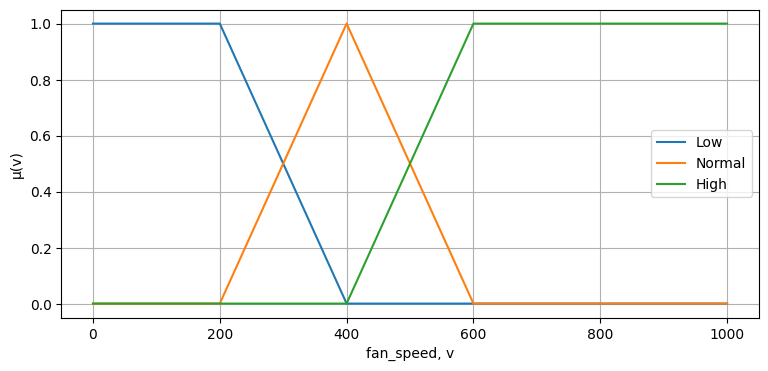

In [14]:
# --- μ_Low(v) ---
low = np.zeros_like(f, float)
low[(f >= 0) & (f <= 200)] = 1
mask = (f > 200) & (f <= 400)
low[mask] = (-1/200)*f[mask] + 2        # 1/200 v + 2
low[f > 400] = 0                        # уже по умолчанию

# --- μ_Normal(v) ---
normal = np.zeros_like(f, float)
mask = (f > 200) & (f <= 400)
normal[mask] = (1/200)*f[mask] - 1      # 1/200 v - 1
mask = (f > 400) & (f <= 600)
normal[mask] = (-1/200)*f[mask] + 3     # -1/200 v + 3

# --- μ_High(v) ---
high = np.zeros_like(f, float)
mask = (f > 400) & (f <= 600)
high[mask] = (1/200)*f[mask] - 2        # 1/200 v - 2
high[(f > 600) & (f <= 1000)] = 1

fan_speed["low"] = low
fan_speed["normal"] = normal
fan_speed["high"] = high

# --- График ---
plt.figure(figsize=(9,4))
plt.plot(f, low,   label='Low')
plt.plot(f, normal,label='Normal')
plt.plot(f, high,  label='High')
plt.ylim(-0.05,1.05)
plt.grid(True)
plt.xlabel('fan_speed, v')
plt.ylabel('μ(v)')
plt.legend()
plt.show()


In [27]:
rule1 = ctrl.Rule(temperature['high'], fan_speed['high'])
rule2 = ctrl.Rule(temperature['normal'], fan_speed['normal'])
rule3 = ctrl.Rule(temperature['low'], fan_speed['low'])
cooling_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
cooling = ctrl.ControlSystemSimulation(cooling_ctrl)
sim = ctrl.ControlSystemSimulation(cooling_ctrl)


624.4444444444445


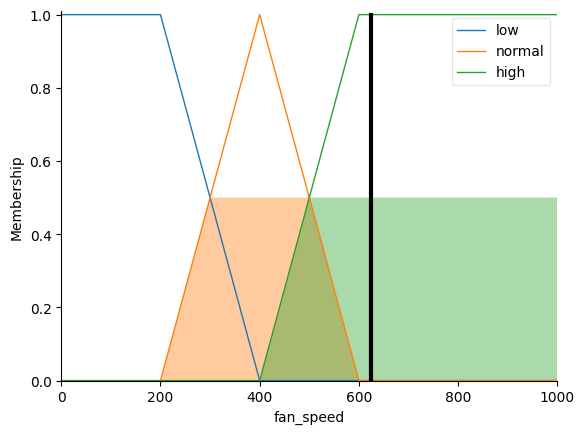

In [28]:
cooling.input['temperature'] = 24   # например температура 35

cooling.compute()
print(cooling.output['fan_speed'])
fan_speed.view(sim=cooling)


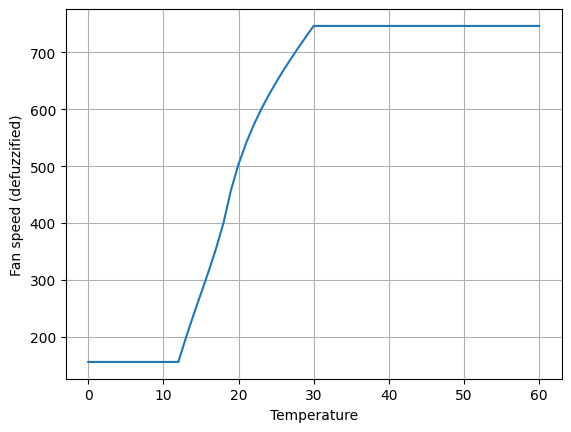

In [21]:
temps = np.arange(0, 61, 1)
outputs = []

for t in temps:
    cooling.input['temperature'] = t
    cooling.compute()
    outputs.append(cooling.output['fan_speed'])

plt.plot(temps, outputs)
plt.xlabel('Temperature')
plt.ylabel('Fan speed (defuzzified)')
plt.grid(True)
plt.show()

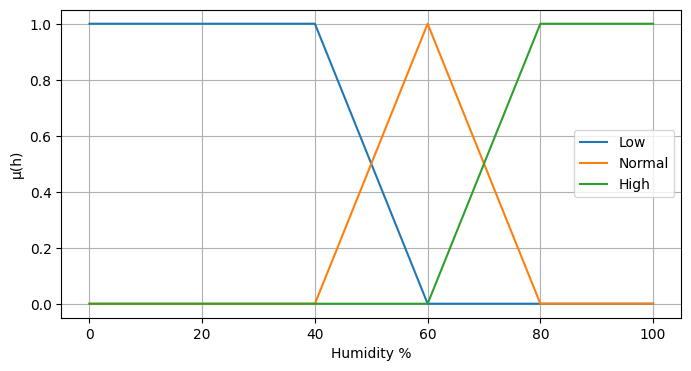

In [23]:
# --- Универсум влажности ---
h = np.arange(0, 101, 1)

# --- μ_Low(h) ---
hum_low = np.zeros_like(h, float)
hum_low[(0 <= h) & (h <= 40)] = 1
mask = (h > 40) & (h <= 60)
hum_low[mask] = -(1/20)*h[mask] + 3     # -1/20*h + 3
hum_low[h > 60] = 0

# --- μ_Normal(h) ---
hum_normal = np.zeros_like(h, float)
mask = (h > 40) & (h <= 60)
hum_normal[mask] = (1/20)*h[mask] - 2   # 1/20*h - 2
mask = (h > 60) & (h <= 80)
hum_normal[mask] = -(1/20)*h[mask] + 4  # -1/20*h + 4

# --- μ_High(h) ---
hum_high = np.zeros_like(h, float)
mask = (h > 60) & (h <= 80)
hum_high[mask] = (1/20)*h[mask] - 3     # 1/20*h - 3
hum_high[(h > 80) & (h <= 100)] = 1

plt.figure(figsize=(8,4))
plt.plot(h, hum_low,    label='Low')
plt.plot(h, hum_normal, label='Normal')
plt.plot(h, hum_high,   label='High')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.xlabel('Humidity %')
plt.ylabel('μ(h)')
plt.legend()
plt.show()

In [24]:
humidity = ctrl.Antecedent(h, 'humidity')

humidity['low']    = hum_low
humidity['normal'] = hum_normal
humidity['high']   = hum_high

In [29]:
rule1 = ctrl.Rule(temperature['high']   & humidity['high'],   fan_speed['high'])
rule2 = ctrl.Rule(temperature['high']   & humidity['normal'], fan_speed['high'])
rule3 = ctrl.Rule(temperature['high']   & humidity['low'],    fan_speed['high'])

rule4 = ctrl.Rule(temperature['normal'] & humidity['high'],   fan_speed['high'])
rule5 = ctrl.Rule(temperature['normal'] & humidity['normal'], fan_speed['normal'])
rule6 = ctrl.Rule(temperature['normal'] & humidity['low'],    fan_speed['normal'])

rule7 = ctrl.Rule(temperature['low']    & humidity['high'],   fan_speed['normal'])
rule8 = ctrl.Rule(temperature['low']    & humidity['normal'], fan_speed['low'])
rule9 = ctrl.Rule(temperature['low']    & humidity['low'],    fan_speed['low'])

In [30]:
cooling_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
cooling = ctrl.ControlSystemSimulation(cooling_ctrl)

400.0000000000002


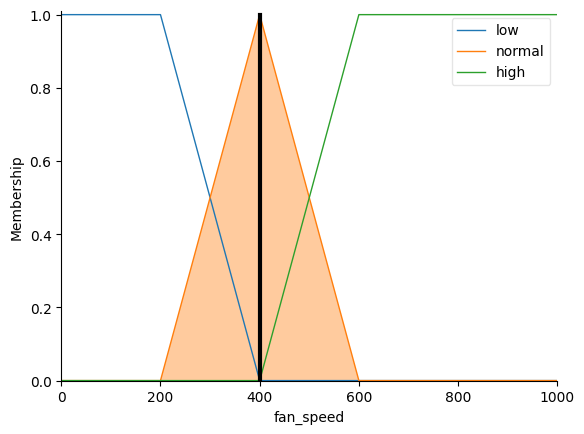

In [38]:
cooling.input['temperature'] = 1
cooling.input['humidity'] = 100

cooling.compute()
print(cooling.output['fan_speed'])
fan_speed.view(sim=cooling)


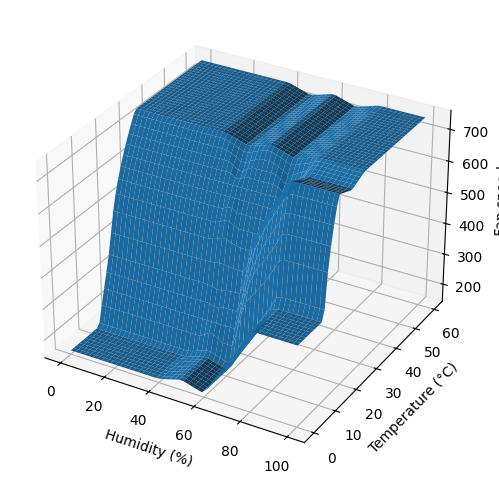

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Сетка входных значений
T = np.linspace(0, 60, 50)   # temperature range
H = np.linspace(0, 100, 50)  # humidity range

Z = np.zeros((len(T), len(H)))

# Считаем выход на сетке
for i, t in enumerate(T):
    for j, h in enumerate(H):
        cooling.input['temperature'] = t
        cooling.input['humidity'] = h
        cooling.compute()
        Z[i, j] = cooling.output['fan_speed']

# mesh для графика
Tg, Hg = np.meshgrid(H, T)   # ВНИМАНИЕ: порядок для Z.T

# Рисуем
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Tg, Hg, Z, linewidth=0, antialiased=True)

ax.set_xlabel('Humidity (%)')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('Fan speed')
plt.show()
